<a href="https://colab.research.google.com/github/blackmeadowAP/PythonScripts/blob/main/trainMnist.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import zipfile
import os
import time
import shutil
from google.colab import drive
from PIL import Image

import tensorflow as tf
#import tensorflow_datasets as tfds
from keras.utils.vis_utils import plot_model
import numpy as np

import pandas as pd
import matplotlib.pyplot as plt
import inspect
from tqdm import tqdm
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
print(os.getcwd())
os.chdir('/content/drive/MyDrive/Classification/mnist')
print(os.getcwd())

/content
/content/drive/MyDrive/Classification/mnist


In [ ]:
#распаковка архивов с датасетами
shutil.unpack_archive('/content/drive/MyDrive/Classification/mnist/IMG/train/0/0 train.zip', '/content/drive/MyDrive/Classification/mnist/IMG/train/0')
shutil.unpack_archive('/content/drive/MyDrive/Classification/mnist/IMG/train/1/1 train.zip', '/content/drive/MyDrive/Classification/mnist/IMG/train/1')
shutil.unpack_archive('/content/drive/MyDrive/Classification/mnist/IMG/test/0/0 test.zip', '/content/drive/MyDrive/Classification/mnist/IMG/test/0')
shutil.unpack_archive('/content/drive/MyDrive/Classification/mnist/IMG/test/1/1 test.zip', '/content/drive/MyDrive/Classification/mnist/IMG/test/1')

In [4]:
batch_size = 128
image_size = (256, 256)
num_classes = 2

image_tr = os.path.join("IMG","train")
image_val = os.path.join("IMG","test")

train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    image_tr,
    seed=1337,
    image_size=image_size,
    batch_size=batch_size
)
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    image_val,
    seed=1337,
    image_size=image_size,
    batch_size=batch_size
)

num_iterations = int(len(train_ds.file_paths)/batch_size) + 1


train_ds = train_ds.map(lambda image, label: (tf.image.resize(image, image_size), label))
val_ds = val_ds.map(lambda image, label: (tf.image.resize(image, image_size), label))

print(len(train_ds))

img_augmentation = tf.keras.models.Sequential(
    [
        tf.keras.layers.RandomRotation(factor=0.15),
        tf.keras.layers.RandomTranslation(height_factor=0.1, width_factor=0.1),
        tf.keras.layers.RandomFlip(),
        tf.keras.layers.RandomContrast(factor=0.1),

    ],
    name="img_augmentation",
)


def input_preprocess(image, label):
    label = tf.one_hot(label, num_classes)
    return image, label


train_ds = train_ds.map(
    input_preprocess, num_parallel_calls=tf.data.AUTOTUNE
)
train_ds = train_ds.prefetch(tf.data.AUTOTUNE)

val_ds = val_ds.map(input_preprocess)


inputs = tf.keras.layers.Input(shape=(image_size[0], image_size[1], 3))
x = img_augmentation(inputs)

model = tf.keras.applications.EfficientNetB0(include_top=False, input_tensor=x, weights="noisy.student.notop-b0.h5", classes=num_classes)
#model = tf.keras.applications.EfficientNetB0(include_top=False, input_tensor=x, classes=num_classes)

# Freeze the pretrained weights
model.trainable = False

# Rebuild top
x = tf.keras.layers.GlobalAveragePooling2D(name="avg_pool")(model.output)
x = tf.keras.layers.BatchNormalization()(x)

top_dropout_rate = 0.6
x = tf.keras.layers.Dropout(top_dropout_rate, name="top_dropout")(x)
outputs = tf.keras.layers.Dense(num_classes, activation="softmax", name="pred")(x)

model = tf.keras.Model(inputs, outputs, name="EfficientNet")

#plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)
#print(model.summary())

learning_rate = 1e-4

def unfreeze_model(model):
    # We unfreeze the top 20 layers while leaving BatchNorm layers frozen
    for layer in model.layers[-20:]:
        if not isinstance(layer, tf.keras.layers.BatchNormalization):
            layer.trainable = True

    #learning_rate = 1e-4
    optimizer = tf.keras.optimizers.Adam(learning_rate)
    model.compile(
        optimizer=optimizer, loss="categorical_crossentropy", metrics=["accuracy"]
    )


unfreeze_model(model)

epochs = 10
hist = model.fit(train_ds, epochs=epochs, validation_data=val_ds, verbose=2, batch_size=batch_size)


model.save(f'E:{epochs}_LR:{learning_rate}_B:{batch_size}.h5')

Found 2330 files belonging to 2 classes.
Found 967 files belonging to 2 classes.
19
Epoch 1/10
19/19 - 752s - loss: 0.1423 - accuracy: 0.9412 - val_loss: 0.1615 - val_accuracy: 0.9990 - 752s/epoch - 40s/step
Epoch 2/10
19/19 - 13s - loss: 0.0151 - accuracy: 0.9961 - val_loss: 0.1018 - val_accuracy: 1.0000 - 13s/epoch - 683ms/step
Epoch 3/10
19/19 - 13s - loss: 0.0109 - accuracy: 0.9970 - val_loss: 0.0774 - val_accuracy: 1.0000 - 13s/epoch - 663ms/step
Epoch 4/10
19/19 - 12s - loss: 0.0088 - accuracy: 0.9966 - val_loss: 0.0599 - val_accuracy: 1.0000 - 12s/epoch - 627ms/step
Epoch 5/10
19/19 - 12s - loss: 0.0064 - accuracy: 0.9970 - val_loss: 0.0483 - val_accuracy: 1.0000 - 12s/epoch - 607ms/step
Epoch 6/10
19/19 - 14s - loss: 0.0047 - accuracy: 0.9991 - val_loss: 0.0387 - val_accuracy: 1.0000 - 14s/epoch - 735ms/step
Epoch 7/10
19/19 - 12s - loss: 0.0043 - accuracy: 0.9983 - val_loss: 0.0300 - val_accuracy: 1.0000 - 12s/epoch - 621ms/step
Epoch 8/10
19/19 - 13s - loss: 0.0070 - accuracy

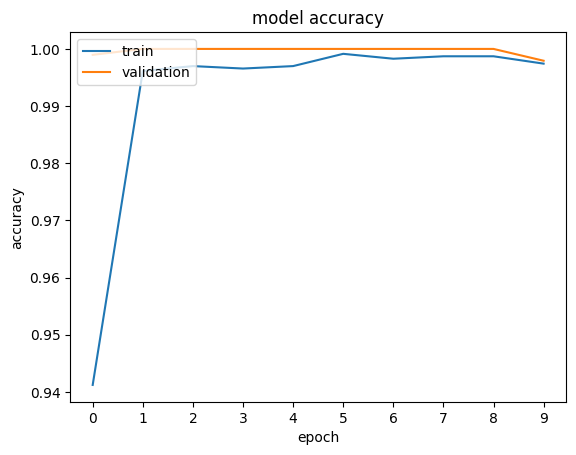

In [17]:
def plot_hist(hist):
    plt.plot(hist.history["accuracy"])
    plt.plot(hist.history["val_accuracy"])
    plt.title("model accuracy")
    plt.ylabel("accuracy")
    plt.xlabel("epoch")
    plt.xticks(np.arange(epochs))
    plt.legend(["train", "validation"], loc="upper left")
    plt.show()


plot_hist(hist)